# Dataset Generation for Anomaly Detection (using MNIST Dataset)

## 0. Import Libraries and Initializations

In [57]:
import pandas as pd
import numpy as np
import keras as K
import sklearn
import matplotlib.pyplot as plt
import networkx as nx
import random
import os
os.chdir('C:\\Users\\user11\\Desktop\\AMAT Interview Task\\MNIST')

In [58]:
# fix random seed for reproducibility
seed = 35
np.random.seed(seed)

## 1. Load Data

The dataset can be found on Kaggle so we will download it from there. The data from Kaggle is already divided into train and test sets. Of course, all our exploration and model building will be on the train set and the test set will only be used for final prediction.

In [59]:
# load data
data_train = pd.read_csv('mnist_train.csv')
data_test = pd.read_csv('mnist_test.csv')

## 2. Data Exploration

Before we start, first we need to explore our dataset and understand its characteristics.

In [60]:
data_train.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


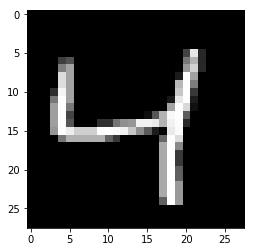

In [61]:
sample = data_train.iloc[2,1:].values
sample = sample.reshape(28,28).astype('uint8')
plt.imshow(sample, cmap=plt.get_cmap('gray'))

In [62]:
#Check for missing values
data_train.isnull().sum().sum()

0

Let's get some basic info and insights about the data we have.

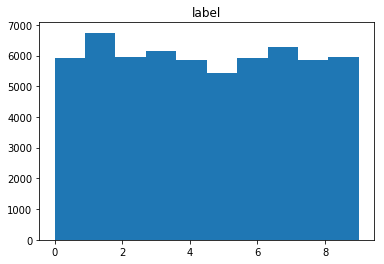

In [63]:
data_train.hist(column = 'label', grid = False);

We can see that the labels are distributed pretty equal. We need to take that into account before divind our train set into train and validation sets for a better, more real world application.

## 3. Data Preprocessing

Let's separate the features (pixel values) from the labels.

In [64]:
X_train = data_train.iloc[:, 1:785]
y_train = data_train.iloc[:, 0]

### 3.1 Train Validation Split

And split our data for training and validation.

In [65]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = seed)
print('X_train shape: ', X_train.shape, 
      '\ny_train shape: ', y_train.shape, 
      '\nX_val shape: ', X_val.shape, 
      '\ny_val shape: ', y_val.shape)

X_train shape:  (48000, 784) 
y_train shape:  (48000,) 
X_val shape:  (12000, 784) 
y_val shape:  (12000,)


### 3.2 Data Normalization

In [66]:
print((min(X_train.iloc[1,:]), max(X_train.iloc[1,:])))

(0, 255)


In [67]:
# normalize inputs from 0-255 to 0-1
X_train = X_train / 255
X_val = X_val / 255

print((min(X_train.iloc[1,:]), max(X_train.iloc[1,:])))

(0.0, 1.0)


## 4. Dataset Generation

From here on we will be implementing the paper "Systematic Construction of Anomaly Detection Benchmarks from Real Data" by Andrew F. Emmot et al. 

### 4.1 Model Building

In order to start the generation of the data by using a multi-class dataset, we start by training a Random Forest to solve the multi-class classification problem.

In [68]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

In [69]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=seed)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_val)
acc_rf = accuracy_score(y_val, y_pred_rf)

print("random forest accuracy: ", acc_rf)

random forest accuracy:  0.9669166666666666


It can be seen that we got to more than 96% accuracy on our validation set. This is not bad at all and we will be going on with this model.

### 4.2 Confusion Matrix

In [70]:
from sklearn.metrics import confusion_matrix

In [71]:
lbls = [0,1,2,3,4,5,6,7,8,9]
conf = confusion_matrix(y_val, y_pred_rf, labels=lbls)

In [72]:
conf

array([[1194,    0,    0,    0,    0,    2,    4,    0,    4,    0],
       [   0, 1347,    8,    0,    2,    0,    2,    2,    1,    2],
       [   4,    3, 1175,    6,    7,    1,    3,    7,   10,    1],
       [   3,    1,   17, 1140,    0,   20,    1,   11,   15,    7],
       [   2,    4,    2,    0, 1135,    0,    5,    1,    0,   17],
       [   5,    2,    2,   13,    2, 1006,    9,    2,   10,    5],
       [   8,    2,    0,    0,    2,    9, 1129,    0,    4,    0],
       [   1,    1,    9,    1,    5,    1,    0, 1193,    2,   12],
       [   1,   10,    5,    9,    4,   10,    5,    2, 1154,   12],
       [   6,    1,    1,   17,   11,    6,    0,   10,    5, 1130]],
      dtype=int64)

### 4.3 Creating the Graph

In [73]:
G=nx.Graph()
G.add_nodes_from([0,1,2,3,4,5,6,7,8,9])

In [74]:
edges = np.identity(len(lbls))
for j in lbls:
    for k in lbls:
        if j != k:
            edges[j][k] = int(conf[j][k] + conf[k][j])
            G.add_edge(j,k, weight=edges[j][k])

c:\users\user11\anaconda3\envs\tensorflow_env2\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


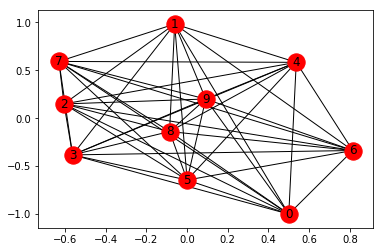

In [75]:
nx.draw_networkx(G)
plt.show()

### 4.4 Maximum Spanning Tree

In oreder to get this we will use Kruskal's algorithm.

In [76]:
from networkx.algorithms.tree.mst import maximum_spanning_tree 
from networkx.algorithms.coloring import greedy_color

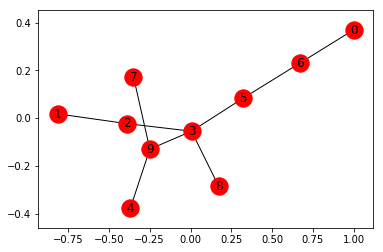

In [79]:
T = nx.maximum_spanning_tree(G, algorithm='kruskal')
nx.draw_networkx(T)
plt.show()

### 4.4 Labeling the points

In [24]:
normal_nodes = [4,7,3,1,6]
anomalous_nodes = [9,2,5,8,0]

In [82]:
data_train['if_outlier'] = 0
data_train.loc[data_train['label'].isin(anomalous_nodes) ,'if_outlier']= 1

data_test['if_outlier'] = 0
data_test.loc[data_test['label'].isin(anomalous_nodes) ,'if_outlier']= 1

Let's see our new dataset with the added _anomalies_!

In [83]:
data_train.head(10)

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28,if_outlier
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
6,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


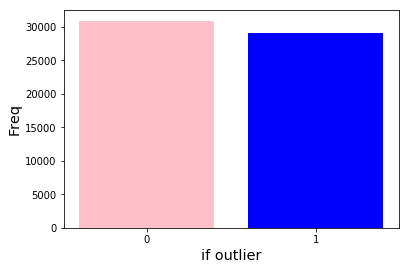

In [89]:
anomalies = data_train[['label', 'if_outlier']].groupby('if_outlier', as_index=False).count()

#Create bar plot
plt.bar(np.arange(len(anomalies['if_outlier'])), anomalies['label'], tick_label=['0','1'], color = ['pink', 'blue'])

plt.xlabel("if outlier", fontsize = 'x-large')
plt.ylabel("Freq", fontsize = 'x-large')
plt.show()

We can see that the distribution is pretty much the same.

### 4.5 Downsampling the Anomalous Points

In [85]:
data_train_normal = data_train[data_train['if_outlier'] == 0]
data_train_anomaly = data_train[data_train['if_outlier'] == 1]

In [86]:
data_train_anomaly_ds = sklearn.utils.resample(data_train_anomaly, 
                                               replace=False, 
                                               n_samples= int(len(data_train_normal)*0.05), 
                                               random_state=seed)

#Merge the downsampled anomalous points to the normal points to get the final dataset
data_train_final = pd.concat([data_train_normal, data_train_anomaly_ds])

Now that we also downsampled the anomalous points, we can check the final distribution of the normal and anomalous points.

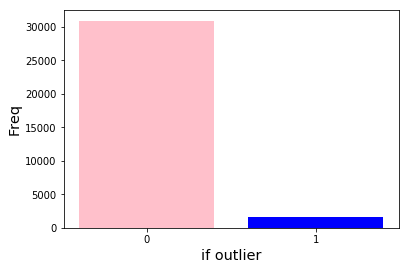

In [88]:
anomalies2 = data_train_final[['label', 'if_outlier']].groupby('if_outlier', as_index=False).count()

#Create bar plot
plt.bar(np.arange(len(anomalies2['if_outlier'])), anomalies2['label'], tick_label=['0','1'], color = ['pink', 'blue'])

plt.xlabel("if outlier", fontsize = 'x-large')
plt.ylabel("Freq", fontsize = 'x-large')
plt.show()

## 5. Benchmarking

We will use 3 different approaches on our newly generated dataset. 2 classical approaches and 1 based on deep learning. 

In [90]:
#We don't need the label feature anymore as we already used it to define the normal/anomalous points.
df = data_train_final.copy()
df = df.drop(columns = 'label', axis=1 )

In [91]:
df.head()

,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,1x10,...,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28,if_outlier
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [97]:
X_train = df.iloc[:, 0:784]
y_train = df.iloc[:, -1]
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, test_size = 0.3, random_state = seed)
print('X_train shape: ', X_train.shape, 
      '\ny_train shape: ', y_train.shape, 
      '\nX_val shape: ', X_val.shape, 
      '\ny_val shape: ', y_val.shape)

X_train shape:  (22709, 784) 
y_train shape:  (22709,) 
X_val shape:  (9733, 784) 
y_val shape:  (9733,)


### Dimensionality Reduction

In [98]:
from sklearn.decomposition import PCA

In [99]:
pca = PCA(0.92)
pca.fit(X_train)

X_train = pca.transform(X_train)
X_val = pca.transform(X_val)

In [100]:
pca.n_components_

102

In [104]:
contamination = (y_train.value_counts()[1]) / len(y_train)

In [121]:
from pyod.models.iforest import IForest
from pyod.models.lof import LOF
from pyod.models.auto_encoder import AutoEncoder

In [122]:
IFmodel = IForest(contamination=contamination, random_state=seed)
LOFmodel = LOF(contamination=contamination)
AEmodel = AutoEncoder(epochs=20, contamination=contamination, random_state=seed)

### 5.1 Isolation Forest

In [127]:
IFmodel.fit(X_train)
y_pred_train = IFmodel.predict(X_train)
y_pred_val = IFmodel.predict(X_val)
IF_val_scores = IFmodel.decision_function(X_val)

IFroc = round(roc_auc_score(y_val, IF_val_scores), ndigits=4)

c:\users\user11\anaconda3\envs\tensorflow_env2\lib\site-packages\sklearn\ensemble\iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)


In [128]:
IFroc

0.8077

### 5.2 Local Outlier Factor (LOF)

In [129]:
LOFmodel.fit(X_train)
y_pred_train = LOFmodel.predict(X_train)
y_pred_val = LOFmodel.predict(X_val)
LOF_val_scores = LOFmodel.decision_function(X_val)

LOFroc = round(roc_auc_score(y_val, LOF_val_scores), ndigits=4)

In [130]:
LOFroc

0.748

### 5.3 AutoEncoders

In [132]:
AEmodel.fit(X_train)
y_pred_train = LOFmodel.predict(X_train)
y_pred_val = AEmodel.predict(X_val)
AE_val_scores = AEmodel.decision_function(X_val)

AEroc = round(roc_auc_score(y_val, AE_val_scores), ndigits=4)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 102)               10506     
_________________________________________________________________
dropout_1 (Dropout)          (None, 102)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 102)               10506     
_________________________________________________________________
dropout_2 (Dropout)          (None, 102)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                6592      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
__________

In [133]:
AEroc

0.8283

## 6. Results

In [134]:
results = {'Model' : ['IF', 'LOF', 'AE'], 'Val AUC' : [IFroc, LOFroc, AEroc]}
results_table = pd.DataFrame(results)
results_table

,Model,Val AUC
0,IF,0.8077
1,LOF,0.7480
2,AE,0.8283
